# Gaussain Naive Bayes 

This algorithm will be a *little more* useful in real life, as you will find many datasets with categorical target but with numerical inputs, unlike all features being categorical.

Let's get going ∞

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Again, we will use the given dataset.

In [3]:
X1 = [3.393533211, 3.110073483, 1.343808831, 
     3.582294042, 2.280362439, 7.423436942,
     5.745051997, 9.172168622, 7.792783481,
     7.939820817]
X2 = [2.331273381, 1.781539638, 3.368360954,
      4.67917911 , 2.866990263, 4.696522875,
      3.533989803, 2.511101045, 3.424088941,
      0.791637231]
y = [0] * 5 + [1] * 5

In [4]:
df = pd.DataFrame({"x1": X1, 
                  "x2": X2,
                  "y":y})

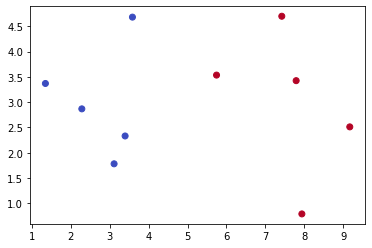

In [4]:
plt.scatter(df.x1, df.x2, c=df.y, cmap="coolwarm")

As discussed in earlier books, we have to use the PDF function instead of Conditional Probability. 
> Though calculation will be done ***like*** conditional probability as we will check each feature X for each unique class.

### $$ PDF = \frac{1} {\sqrt{2\pi} \times \sigma} \times e^{-\left(\frac{(x - \bar x)^2} {2 \times \sigma^2}\right)} $$ 

In [5]:
def pdf(x, mean, std):
    return (1 / (np.sqrt(2 * np.pi) * std)) * np.exp(-(x - mean) ** 2 / 2 * std ** 2)

In [6]:
numbers = np.arange(-5, 6)
numbers

array([-5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5])

In [7]:
pdfed = pdf(numbers, 0, 1)

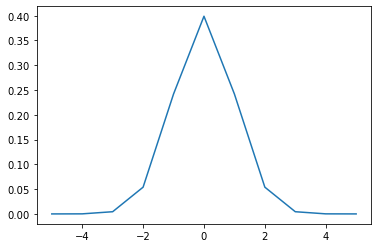

In [8]:
plt.plot(numbers, pdfed)

I don't know, why I did that... but as long as it gives correct output... I think the parenthesis are well balenced in the `pdf` function!

1. Class probability
2. Conditional probability (for each feature, each class)
    - PDF
        - mean
        - std

# 

### 1. Class Probabilities 

In [9]:
class_counts = df.y.value_counts()
class_counts

1    5
0    5
Name: y, dtype: int64

In [10]:
class_probs = class_counts / class_counts.sum()
class_probs

1    0.5
0    0.5
Name: y, dtype: float64

# 

### 2. Conditional Probs 

This is gonna be an amazing part. Here we will make a lookup table as we did in the classification part aka NB part.

The cool thing, is we will do this with a simple pandas call! Just in a single line!

In [11]:
lookup = df.groupby("y").agg(["mean", "std"])
lookup

x1                  x2          
       mean       std      mean       std
y                                        
0  2.742014  0.926568  3.005469  1.107330
1  7.614652  1.234432  2.991468  1.454193

In [12]:
lookup = lookup.swapaxes(1, 0).unstack(0)
lookup

y            0                   1          
            x1        x2        x1        x2
mean  2.742014  3.005469  7.614652  2.991468
std   0.926568  1.107330  1.234432  1.454193

Pretty clean! As I said, we are done. We have learned the values. The model's learnt. Let's get movin' !

# 

### 3. Predict 

Out prediction function will be as usual...

## $$ P(y | X) = {P(X | y) \times P(y)} $$

###### 

But here, we will include a little change... instead of $ P(X | y) $ we will use $ PDF (X | y) $. 

## $$ P(y|X) = PDF(X | y) \times P(y) $$

###### 

And the complete equation will be...

## $$
\begin{equation}
\begin{aligned}
P(y | X) = & PDF(X_1 | y) \\
        & \times PDF(X_2 | y) \\
        & ... \\
        & \times PDF(X_n | y) \\
        & \times P(y) 
\end{aligned}
\end{equation}
$$

***NOTE***: In PDF, we will use the mean and std of corresponding X and Y pair (from lookup).

In [13]:
# Taking first instance
df.iloc[[0]]

,x1,x2,y
0,3.393533,2.331273,0


For class `0`

In [14]:
# For feature X1

row = df.iloc[0].values
learned_values = lookup[(0, "x1")]
class_0_with_x1 = pdf(row[0], learned_values["mean"], learned_values["std"])
class_0_with_x1

0.3588381518290492

In [15]:
# For feature X2

row = df.iloc[0].values
learned_values = lookup[(0, "x2")]
class_0_with_x2 = pdf(row[1], learned_values["mean"], learned_values["std"])
class_0_with_x2

0.2726508887953506

In [16]:
# Plugging in the values
class_0_with_x1 * class_0_with_x2 * class_probs[0]

0.048918770514935615

###### 

For class `1`

In [17]:
# For feature X1

row = df.iloc[0].values
learned_values = lookup[(1, "x1")]
class_0_with_x1 = pdf(row[0], learned_values["mean"], learned_values["std"])
class_0_with_x1

4.1079569148601473e-07

In [18]:
# For feature X2

row = df.iloc[0].values
learned_values = lookup[(1, "x2")]
class_0_with_x2 = pdf(row[1], learned_values["mean"], learned_values["std"])
class_0_with_x2

0.17303901779050074

In [19]:
# Plugging in the values
class_0_with_x1 * class_0_with_x2 * class_probs[1]

3.554184148365478e-08

To the point. Exactly.

Here, class 0 is giving `0.048918` and class 1 is giving `3.554e-08`. Clearly class `0` wins here.

###### 

### Doing this for all instances 

In [20]:
pdfs = []
for index, instance in enumerate(df.iloc[:, :-1].values):
    by_class = {}
    for class_ in df["y"].unique():
        whole = 1
        for column, value in zip(df.columns[:-1], instance):
            learned_values = lookup[(class_, column)]
            pdf_val = pdf(value, learned_values["mean"], learned_values["std"])
            whole *= pdf_val
        whole *= class_probs[class_]
        by_class[class_] = whole
    by_class["winner"] = sorted(by_class.items(), key=lambda i: i[1], reverse=True)[0][0]
    pdfs.append(by_class)

In [21]:
pred = pd.DataFrame(pdfs)
pred

,0,1,winner
0,4.891877e-02,3.554184e-08,0
1,2.920928e-02,1.820649e-09,0
2,3.091081e-02,3.711704e-15,0
3,1.028313e-02,9.087275e-09,0
4,6.995166e-02,1.675389e-11,0
5,1.102891e-06,1.993521e-03,1
6,1.361494e-03,2.264317e-03,1
7,1.307311e-09,5.470650e-03,1
8,1.222273e-06,3.550240e-02,1
9,3.531319e-08,2.452139e-04,1


In [22]:
pred = pd.concat([df, pred], axis=1)
pred

,x1,x2,y,0,1,winner
0,3.393533,2.331273,0,4.891877e-02,3.554184e-08,0
1,3.110073,1.781540,0,2.920928e-02,1.820649e-09,0
2,1.343809,3.368361,0,3.091081e-02,3.711704e-15,0
3,3.582294,4.679179,0,1.028313e-02,9.087275e-09,0
4,2.280362,2.866990,0,6.995166e-02,1.675389e-11,0
5,7.423437,4.696523,1,1.102891e-06,1.993521e-03,1
6,5.745052,3.533990,1,1.361494e-03,2.264317e-03,1
7,9.172169,2.511101,1,1.307311e-09,5.470650e-03,1
8,7.792783,3.424089,1,1.222273e-06,3.550240e-02,1
9,7.939821,0.791637,1,3.531319e-08,2.452139e-04,1


And... our accuracy is 100%. Cool!

# 

**Let's make a compact class here**

In [21]:
%%writefile GNB.py

import math
import numpy as np
import pandas as pd

class GaussianNaiveBayes:
    """
    This is an amazing class.
    I have 
    """
    def __init__(self, data: pd.DataFrame, target: str):
        self.data = data
        self.target = target
        
        if not self.target in self.data:
            raise NotImplementedError("The given target column is not found in the data.")
            
        self.class_counts = self.data[self.target].value_counts()
        self.class_probs = self.class_counts / self.class_counts.sum()
        self.lookup = self.data.groupby(self.target).agg(["mean", "std"])
    
    def predict(self, features):
        feature_names = features.columns
        target = self.data[self.target]

        # For all rows - stores pdfs class wise and winner for that row
        # in the form of dict {0: 0.33, 1: 1.23. winner: 1}
        row_wise_pdf_and_winner = []

        # Iterates through all features (excluding target)
        for row in features.values:
            # Stores the dict {0: 0.33, 1: 1.23. winner: 1}
            # It gets appended in the maind row_wise... ↑ list.
            pdfs_target_wise = {}

            # Iterates through all unique classes
            for target_class in target.unique():
                # Stores all pdfs feature wise. Then we will use
                # it to perform product [0.22, 0.32, 0.12] (in 3 features data)
                pdfs_for_that_target_class = []

                # Maps the feature name with its values to make
                # it easier in lookup
                for column, its_value in zip(feature_names, row):
                    # Returns mean and std from lookup
                    # for that class and feature
                    learned_values = self.lookup.loc[target_class, column]

                    # Appends featurewise pdf in list (then we will multiply)
                    pdfs_for_that_target_class.append(
                        self.pdf(its_value, learned_values["mean"], learned_values["std"]))

                # For that class, we will return the pdf. After multiplying all
                pdfs_target_wise[target_class] = math.prod(pdfs_for_that_target_class) * self.class_probs[target_class]

            pdfs_target_wise["winner"] = sorted(pdfs_target_wise.items(), key=lambda i: i[1], reverse=True)[0][0]
            row_wise_pdf_and_winner.append(pdfs_target_wise)
        return row_wise_pdf_and_winner
    
    @staticmethod
    def pdf(x, mean, std):
        return (1 / (np.sqrt(2 * np.pi) * std)) * np.exp(-(x - mean) ** 2 / (2 * std ** 2)) 

Overwriting GNB.py


With previously used dataset.

In [5]:
obj = GNB(df, "y")

In [6]:
obj.predict(df.drop("y", axis=1))

[{0: 0.05032427673372075, 1: 0.00011557718379945795, 'winner': 0},
 {0: 0.03891229878967955, 1: 4.0257123132694387e-05, 'winner': 0},
 {0: 0.02354195769052508, 1: 1.0677123311147688e-07, 'winner': 0},
 {0: 0.016404353839568914, 1: 0.00010893052118437212, 'winner': 0},
 {0: 0.06797274932849018, 1: 3.892920735657439e-06, 'winner': 0},
 {0: 6.919582110595242e-08, 1: 0.022027299133895104, 'winner': 1},
 {0: 0.00036240188135671443, 1: 0.013133373825769757, 'winner': 1},
 {0: 2.4462998433695283e-12, 1: 0.01893726496422881, 'winner': 1},
 {0: 2.5486090623409473e-08, 1: 0.04197206997894985, 'winner': 1},
 {0: 1.5425966116475593e-09, 1: 0.013636752786743601, 'winner': 1}]

Great!

###### 

#### On another dataset 

In [7]:
import seaborn as sns
iris = sns.load_dataset("iris")

In [18]:
obj = GNB(iris, "species")

In [9]:
pred = obj.predict(iris.drop("species", axis=1))
pred[:5]

[{'setosa': 2.7915339171768885,
  'versicolor': 8.322426199968102e-18,
  'virginica': 6.008422572011112e-25,
  'winner': 'setosa'},
 {'setosa': 1.4881643294772486,
  'versicolor': 4.7164568365711915e-17,
  'virginica': 1.032492867373919e-24,
  'winner': 'setosa'},
 {'setosa': 1.1631447162337678,
  'versicolor': 2.75329452765188e-18,
  'virginica': 8.422280209499679e-26,
  'winner': 'setosa'},
 {'setosa': 1.0857654378277553,
  'versicolor': 3.332872173551793e-17,
  'virginica': 9.435991991074538e-25,
  'winner': 'setosa'},
 {'setosa': 2.65673752883528,
  'versicolor': 2.7027983119749797e-18,
  'virginica': 2.360722138204101e-25,
  'winner': 'setosa'}]

In [10]:
pred = pd.concat([iris, pd.DataFrame(pred)], axis=1)
(pred["species"] == pred["winner"]).sum() / pred.shape[0]

0.96

# `96%`
Isn't that freakin' awsome!

# 

Let's try it in our built in `sklearn`.

In [11]:
from sklearn.naive_bayes import GaussianNB, CategoricalNB

In [13]:
model = GaussianNB()
X = iris.drop("species", axis=1)
y = iris["species"]
model.fit(X, y)

GaussianNB()

In [14]:
pred = model.predict(X)

In [15]:
(pred == y).sum() / len(y)

0.96

### Same!!!